# Data handling, exploration and pca 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as matplot
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import pymc3 as pm

from linearmodels import OLS

import time

In [2]:
df = pd.read_csv('used.csv', index_col=0)
#df2 = pd.read_csv('original.csv',index_col=0)

In [3]:
df.head()

,SN_2,Questionnaire,gn,ds,District,Province,A1_1,A1_2,A1_3,A1_4,...,trust_eth,reconcile1,reconcile2,reconcile2add,reconcile1add,tol_buddhist,tol_christ,prewar,rights_sinhaleseALL,ethnic2
1,1,1,32,33,3,1,1,2.0,3.0,5.0,...,2.0,1.559590,-0.047157,1.5,2.5,NaN,NaN,0,3.0,2.0
2,2,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.038614,-0.125119,1.5,1.5,NaN,NaN,0,3.0,2.0
3,3,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.311233,-0.532862,1.5,1.5,NaN,NaN,0,2.0,2.0
4,4,1,32,33,3,1,1,2.0,3.0,3.0,...,2.0,0.038614,-0.125119,1.5,1.5,NaN,NaN,0,2.0,2.0
5,5,1,32,33,3,1,1,2.0,3.0,3.0,...,1.0,-0.982462,-0.235567,1.5,1.0,NaN,NaN,0,2.0,2.0


Carolins growth index':

** df['my_growth1']=(df['E2a']+df['E2c']+df['E2f']+df['E2g']+df['E2i']+df['E2j'])/6** 

** df['my_growth2']=(df['E2b']+df['E2d']+df['E2e']+df['E2h'])/4**

- E2a = I changed my priorities about what is important in life
- E2b = I have a greater appreciation for the value of my own life.
- E2c = I am able to do better thins with my life.
- E2d = I have a better understanding of spiritual matters. (USE: from growth2)
- E2e = I have a greater sense of closeness with others.
- E2f = I established a new path for my life. (USE: from growth1)
- E2g = I know better that I can handle difficulties.
- E2h = I have a stronger religious faith (USE: from growth2)
- E2i = I discovered that I’m stronger than I thought I was. (USE: growth1)
- E2j = I learned a great deal about how wonderful people are.

Thus I use E2d(2) E2f(1) E2h(2) E2i(1) for the estimations Both as indexes and for them selfs.

The components of rights_sinhalese:

For instance Sinhala. Do you think that
members of this ethnic group should be allowed to...

- C30a = hold official government positions
- C30c = make a speech in this village/city/town/community?
- C30e = to hold public demonstrations?
    

In [4]:
# Getting carolins data + religiosity: 

# taget components: C30a+C30c+C30e ( if tamil1==1 )

df_carolin = df[df['tamil2']==1][['rights_sinhalese','distress','war','gender','age','edu','eduf','growth1', 'growth2',
                                  'E2a','E2c','E2f','E2g','E2i','E2j','E2b','E2d','E2e','E2h','religiosity',
                                  'C30a', 'C30c', 'C30e']].dropna().copy()

# full additive index
df_carolin['growth_full'] = (df_carolin['E2a']+df_carolin['E2c']+df_carolin['E2f']+df_carolin['E2g']+
                             df_carolin['E2i']+df_carolin['E2j'] + df_carolin['E2b']+df_carolin['E2d']+
                             df_carolin['E2e']+df_carolin['E2h'])/10

# minor religous growth index:
df_carolin['growth_religion'] = (df_carolin['E2h'] +  df_carolin['E2d'])/2

# minor new stength index
df_carolin['growth_new_strenght'] =  (df_carolin['E2f'] +  df_carolin['E2i'])/2

df_carolin.shape

(358, 26)

# data exploration:

In [5]:
# def plot_lin_color(x,y,z, df=df_carolin , xlabel = 'x', ylabel = 'y', zlabel = 'z',title = 'title', alpha = 0.2, jitter = 0.08):

#     plt.figure(figsize=[9,3])
#     colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

#     plt.title(title)
    
#     z = df[z]
#     x = df[x]
#     y = df[y]
#     n = len(x) 

#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     line = slope*x+intercept


#     label = 'Slope = ' + str(round(slope,3)) + \
#         '\n' + 'Intercept = ' + str(round(intercept,3)) + \
#         '\n' + 'R² = ' + str(round(r_value,3)) +\
#         '\n' + 'P_values < : ' + str(round(p_value,3)) +\
#         '\n' + 'Śtd_err = ' + str(round(std_err,3))
        
#     jitterx = np.random.normal(0,scale = jitter, size = n)
#     jittery =  np.random.normal(0,scale = jitter, size = n)
    
#     plt.scatter(x + jitterx, y+jittery , alpha = alpha, label = '', c = z, cmap = 'Reds')# matplot.colors.ListedColormap(colors))
#     cb = plt.colorbar(label = zlabel)

#     plt.plot(x, line, '-', label = label, alpha = 1, color = colors[1])

#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

#     sns.despine(left = True, bottom = True)
#     plt.legend(loc = 2, frameon = True)
#     plt.show()

#     print(n)

In [6]:
def plot_lin(x,y, df=df_carolin , xlabel = 'x', ylabel = 'y', title = 'title', alpha = 0.2, jitter = 0.08):

    plt.figure(figsize=[9,3])
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.title(title)
    
    x = df[x]
    y = df[y]
    n = len(x) 

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept


    label = 'Slope = ' + str(round(slope,3)) + \
        '\n' + 'Intercept = ' + str(round(intercept,3)) + \
        '\n' + 'R² = ' + str(round(r_value,3)) +\
        '\n' + 'P_values < : ' + str(round(p_value,3)) +\
        '\n' + 'Śtd_err = ' + str(round(std_err,3))
        
    jitterx = np.random.normal(0,scale = jitter, size = n)
    jittery =  np.random.normal(0,scale = jitter, size = n)
    
    plt.scatter(x + jitterx, y+jittery , alpha = alpha, label = '', color = colors[0])

    plt.plot(x, line, '-', label = label, alpha = 1, color = colors[1])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    sns.despine(left = True, bottom = True)
    plt.legend(loc = 2,frameon = True)
    plt.show()

    print(n)

In [7]:
# plot_lin_color('E2h','E2d','religiosity', xlabel = 'Stronger Religon', ylabel='Spiritual matters', zlabel='Religiosity', alpha=1)

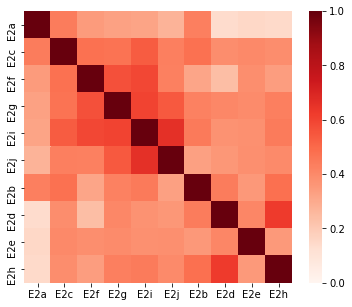

In [8]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[['E2a','E2c','E2f','E2g','E2i','E2j','E2b','E2d','E2e','E2h']].corr(), cmap="Reds", vmin = 0)
plt.show()

But could E2j (wonderfull people) be interesting

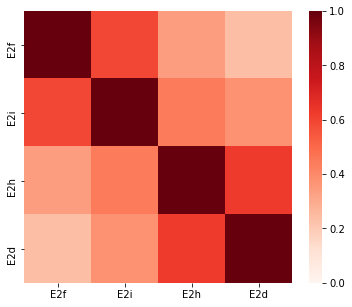

In [9]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[['E2f','E2i','E2h','E2d']].corr(), cmap="Reds", vmin = 0)
plt.show()

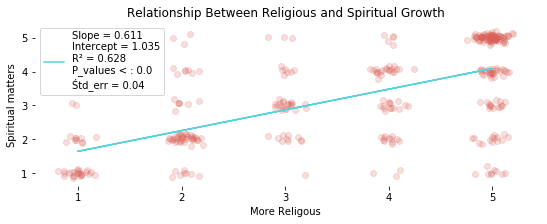

358


In [10]:
plot_lin('E2h','E2d', xlabel = 'More Religous', ylabel='Spiritual matters', title='Relationship Between Religious and Spiritual Growth')

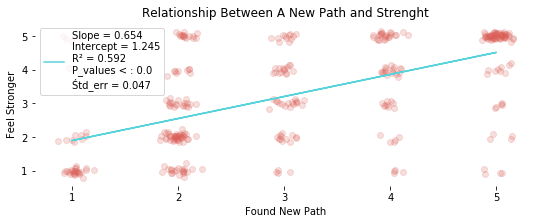

358


In [11]:
plot_lin('E2f','E2i', xlabel = 'Found New Path', ylabel='Feel Stronger', title='Relationship Between A New Path and Strenght')

# And what with destriss, war and the target?

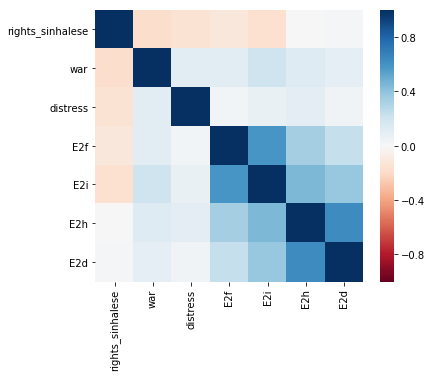

In [12]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[['rights_sinhalese','war','distress','E2f','E2i','E2h','E2d']].corr(), cmap="RdBu", vmin=-1, vmax=1)
plt.show()

**So if you still have one target then you and only wanted to use two: Ed2 (Spiritual) and Ei2 (Stronger)**

# Splitting up the target:
 'C30a', 'C30c', 'C30e'

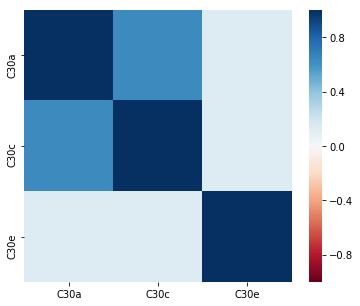

In [13]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[[ 'C30a', 'C30c', 'C30e']].corr(), cmap="RdBu", vmin=-1, vmax=1)
plt.show()

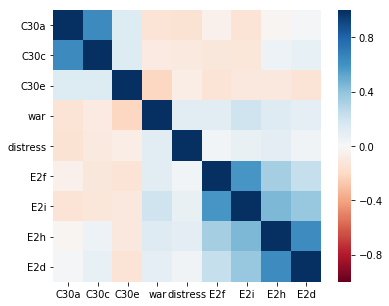

In [14]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[[ 'C30a', 'C30c', 'C30e','war','distress','E2f','E2i','E2h','E2d']].corr(), cmap="RdBu", vmin=-1, vmax=1)
plt.show()

So, C30e, could create some noise..
It does seem like C30c has the most to do with the growth components.
but C30a might be more effected by war.. You can make that model ;)

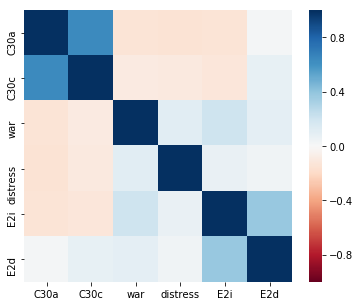

In [15]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[[ 'C30a', 'C30c','war','distress','E2i','E2d']].corr(), cmap="RdBu", vmin=-1, vmax=1)
plt.show()

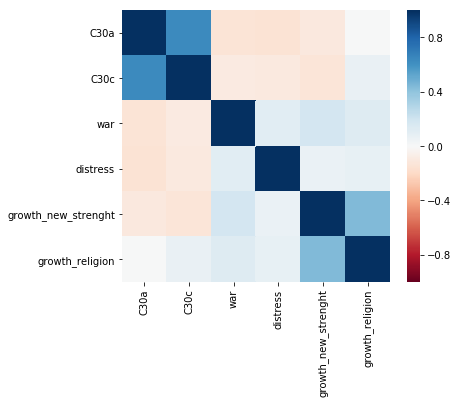

In [16]:
plt.figure(figsize=[6,5])
sns.heatmap(df_carolin[[ 'C30a', 'C30c','war','distress','growth_new_strenght','growth_religion']].corr(), cmap="RdBu", vmin=-1, vmax=1)
plt.show()

# Visualizing the model(s):

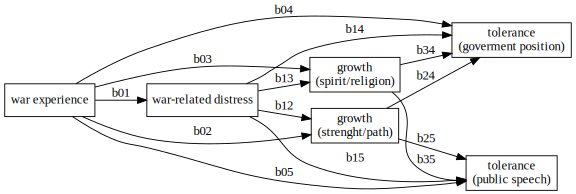

In [17]:
def viz_model():
    
    dot = graphviz.Digraph(comment='COMMENT')
    dot.attr(rankdir='LR', size='8,5', engine='neato')

    dot.attr('node', shape='box')

    dot.node('X0', 'war experience')
    dot.node('X1', 'war-related distress')
    dot.node('X2', 'growth\n(strenght/path)')
    dot.node('X3', 'growth\n(spirit/religion)')


    dot.node('Y0', 'tolerance\n(goverment position)')
    dot.node('Y1', 'tolerance\n(public speech)')

    dot.edge('X0', 'X1', 'b01')
    dot.edge('X0', 'X2', 'b02')
    dot.edge('X0', 'X3', 'b03')
    dot.edge('X0', 'Y0', 'b04')
    dot.edge('X0', 'Y1', 'b05')
    dot.edge('X1', 'X2', 'b12')
    dot.edge('X1', 'X3', 'b13')
    dot.edge('X1', 'Y0', 'b14')
    dot.edge('X1', 'Y1', 'b15')
    dot.edge('X2', 'Y0', 'b24')
    dot.edge('X2', 'Y1', 'b25')
    dot.edge('X3', 'Y0', 'b34')
    dot.edge('X3', 'Y1', 'b35', constraint='false')
    dot.render('my_model', 'pdf')
    
    return(dot)

dot = viz_model()
dot

# Model 0: only stength(E2i from growth1) and spirit(E2d from growth2)

In [18]:
# Features --------------------------------------------------------------------------------------------------------

# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['E2i'] # strength
X3 = df_carolin['E2d'] # spirit

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Targets
Y0 = df_carolin['C30a'] # Position
Y1 = df_carolin['C30c'] # Speech

# model --------------------------------------------------------------------------------------------------------
model0 = pm.Model()

with model0:

    # Priors for unknown model parameters
    
    # All intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 5)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    
    # Beta for X1
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    # Betas for X2
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
    # Betas for X3
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
    beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    # Betas for Y0
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
    beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)
    
    # Betas for Y1
    beta05 = pm.Normal('beta05', mu=0, sd=10, shape=1)
    beta15 = pm.Normal('beta15', mu=0, sd=10, shape=1)
    beta25 = pm.Normal('beta25', mu=0, sd=10, shape=1)
    beta35 = pm.Normal('beta35', mu=0, sd=10, shape=1)
    
    # Controls
    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4) # controls for X1: distrees 
    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4) # controls for Y0
    gamma5 = pm.Normal('gamma5', mu=0, sd=10, shape=4) # controls for Y1 

    # Vector of error-terms
    sigma = pm.HalfNormal('sigma', sd=1, shape=5)#A vector of error-terms

    

    # Expected value of outcome and
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    Y0_obs = pm.Normal('Y0_obs', mu=mu4, sd=sigma[3], observed=Y0)
    
    mu5 = alpha[4] + beta15 * X1_obs + beta05 * X0 + beta25 * X2_obs + beta35 * X3_obs + gamma5[0] * Z0 + gamma5[1] * Z1 + gamma5[2] * Z2 + gamma5[3] * Z3
    Y1_obs = pm.Normal('Y1_obs', mu=mu5, sd=sigma[4], observed=Y1)

    
    
    
    

In [19]:
with model0:
    # draw 1000 posterior samples
    trace0 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace0).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma5, gamma4, gamma1, beta35, beta25, beta15, beta05, beta34, beta24, beta14, beta04, beta13, beta03, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:25<00:00, 93.24draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.510,0.396,0.006,-0.293,1.253,4087.873,1.000
alpha__1,2.401,0.231,0.003,1.968,2.847,4455.173,1.001
alpha__2,2.856,0.213,0.003,2.451,3.287,4679.264,1.000
alpha__3,0.687,0.134,0.002,0.443,0.965,4450.376,1.000
alpha__4,0.520,0.134,0.002,0.257,0.787,4105.756,1.000
beta01__0,0.209,0.086,0.001,0.047,0.388,7994.279,1.000
beta02__0,0.334,0.089,0.001,0.166,0.505,4695.790,1.001
beta12__0,0.051,0.051,0.001,-0.053,0.148,8423.406,1.000
beta03__0,0.148,0.081,0.001,-0.018,0.301,4848.021,1.000
beta13__0,0.028,0.048,0.001,-0.068,0.119,7782.985,1.000


In [20]:
# pm.traceplot(trace0)
# plt.show()

** Pretty much the same as in R. No real differences.**

Make nice beta plots for each step: 

In [248]:
def prop_plot(trace = trace0, trace_nr = '0' , features = ['beta01'], labels = ['beta01'], title = 'title'):
    
    colors = ['indianred','darkcyan','orange','mediumpurple']
    
    plt.figure(figsize=[9,1.8])
    
    legend_dict = {}
    
    for i in range(len(features)):
        
        prop_G_zero = sum(trace.get_values(features[i])[:,0] > 0)/len(trace0.get_values('beta01')[:,0])
        prop_L_zero = sum(trace.get_values(features[i])[:,0] < 0)/len(trace0.get_values('beta01')[:,0])
        
        if prop_G_zero > prop_L_zero:
            
            prop = str(round(prop_G_zero*100,1))
            prop_text = '% > 0'
            
        elif prop_G_zero < prop_L_zero:
            
            prop = str(round(prop_L_zero*100,1))
            prop_text = '% < 0'
            
        elif prop_G_zero == prop_L_zero:
            # does not matter wich you choose, and it will never happen
            prop = str(round(prop_G_zero*100,1))
            prop_text = '% > 0'
            
        else:
            print('error')
        
        best_est = round(trace.get_values(features[i])[:,0].mean(),2)
    
        label = labels[i] + ':\n prop: ' + prop + prop_text + ':\n mean: ' +str(best_est)
        
        kde = sns.kdeplot(trace.get_values(features[i])[:,0], label=label, color = colors[i])
        
        max_val = kde.dataLim.bounds[3]
                
    plt.vlines(0,0,max_val, linestyles="dashed", alpha = 0.8, color = 'gray')
    
    plt.title(title)
    plt.xlabel('Sampled Distribution')
    
    sns.despine(left=True, bottom=True)
    plt.yticks([])
    l1=plt.legend(frameon=False, loc = 2, bbox_to_anchor=(.9, 1.5),  borderaxespad=0.)
    
    fig_title = title.replace(' ', '_').replace('-','_') + '_'  + trace_nr + '.pdf'
    

    plt.savefig(fig_title, bbox_inches="tight")

    
    plt.show()
    print('saved {}'.format(fig_title))
# Du kunne jo også bruge scipy og få rigtige normfordelinger..

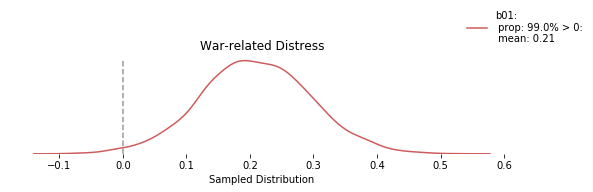

saved War_related_Distress_0.pdf


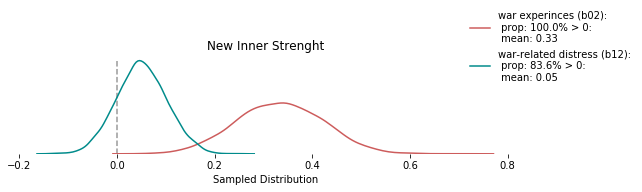

saved New_Inner_Strenght_0.pdf


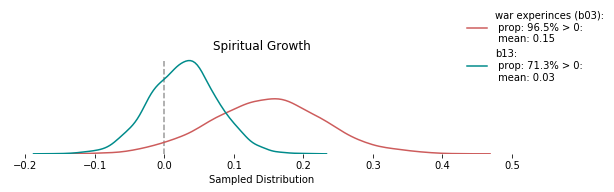

saved Spiritual_Growth_0.pdf


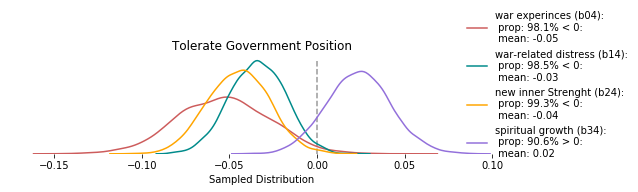

saved Tolerate_Government_Position_0.pdf


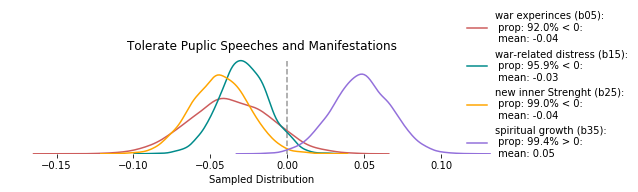

saved Tolerate_Puplic_Speeches_and_Manifestations_0.pdf


In [249]:
prop_plot(title='War-related Distress', labels=['b01'], trace_nr = '0')

prop_plot(features = ['beta02','beta12'], 
          labels = ['war experinces (b02)','war-related distress (b12)'], 
          title='New Inner Strenght', trace_nr = '0')

prop_plot(features = ['beta03','beta13'], 
          labels = ['war experinces (b03)','b13'], 
          title='Spiritual Growth', trace_nr = '0')

prop_plot(features = ['beta04','beta14','beta24','beta34'],
          labels = ['war experinces (b04)','war-related distress (b14)',
                    'new inner Strenght (b24)','spiritual growth (b34)'], 
          title='Tolerate Government Position', trace_nr = '0')

prop_plot(features = ['beta05','beta15','beta25','beta35'], 
          labels = ['war experinces (b05)','war-related distress (b15)',
                    'new inner Strenght (b25)','spiritual growth (b35)'], 
          title='Tolerate Puplic Speeches and Manifestations', trace_nr = '0')

Du kan jo faktisk statistisk tjekker hvor moget mere crediable effecten er på Y1 from for Y0..

det er også vigtig du ser på hvad der er mest af; mest af den ene slags tolerance eller den anden?

# Model 1: the two small index'

In [23]:
# Features --------------------------------------------------------------
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['growth_new_strenght']#['E2i'] # strength
X3 = df_carolin['growth_religion']#['E2d'] # spirit

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Targets
Y0 = df_carolin['C30a'] # Position
Y1 = df_carolin['C30c'] # Speech

# Model ---------------------------------------------------------------------
model1 = pm.Model()

with model1:

    # Priors for unknown model parameters
    
    # All intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 5)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    
    # Beta for X1
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    # Betas for X2
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
    # Betas for X3
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
    beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    # Betas for Y0
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
    beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)
    
    # Betas for Y1
    beta05 = pm.Normal('beta05', mu=0, sd=10, shape=1)
    beta15 = pm.Normal('beta15', mu=0, sd=10, shape=1)
    beta25 = pm.Normal('beta25', mu=0, sd=10, shape=1)
    beta35 = pm.Normal('beta35', mu=0, sd=10, shape=1)
    
    # Controls
    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4) # controls for X1: distrees 
    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4) # controls for Y0
    gamma5 = pm.Normal('gamma5', mu=0, sd=10, shape=4) # controls for Y1 

    # Vector of error-terms
    sigma = pm.HalfNormal('sigma', sd=1, shape=5)#A vector of error-terms

    

    # Expected value of outcome and
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    Y0_obs = pm.Normal('Y0_obs', mu=mu4, sd=sigma[3], observed=Y0)
    
    mu5 = alpha[4] + beta15 * X1_obs + beta05 * X0 + beta25 * X2_obs + beta35 * X3_obs + gamma5[0] * Z0 + gamma5[1] * Z1 + gamma5[2] * Z2 + gamma5[3] * Z3
    Y1_obs = pm.Normal('Y1_obs', mu=mu5, sd=sigma[4], observed=Y1)



In [24]:
with model1:
    # draw 1000 posterior samples
    trace1 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace1).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma5, gamma4, gamma1, beta35, beta25, beta15, beta05, beta34, beta24, beta14, beta04, beta13, beta03, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:31<00:00, 87.04draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.512,0.390,0.007,-0.245,1.258,3338.218,1.000
alpha__1,2.541,0.193,0.003,2.170,2.913,3488.981,1.000
alpha__2,2.950,0.192,0.003,2.578,3.318,6098.903,1.001
alpha__3,0.682,0.136,0.002,0.416,0.946,3837.879,1.000
alpha__4,0.533,0.139,0.002,0.260,0.806,3989.055,1.000
beta01__0,0.209,0.087,0.001,0.049,0.387,6591.317,1.000
beta02__0,0.249,0.073,0.001,0.109,0.394,3627.255,1.000
beta12__0,0.037,0.044,0.000,-0.052,0.120,7882.761,1.000
beta03__0,0.168,0.074,0.001,0.019,0.303,6439.686,1.000
beta13__0,0.057,0.043,0.000,-0.027,0.139,9650.766,1.000


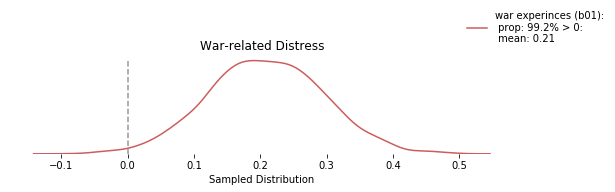

saved War_related_Distress_1.pdf


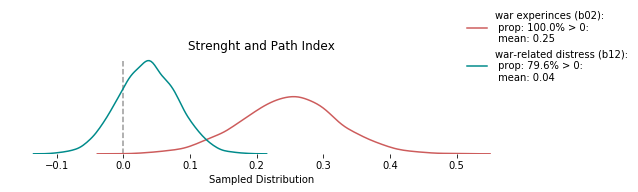

saved Strenght_and_Path_Index_1.pdf


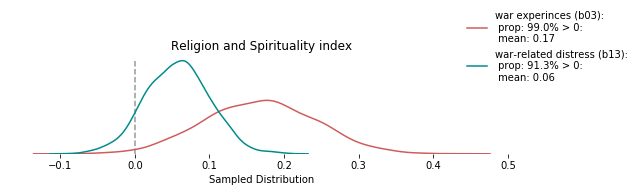

saved Religion_and_Spirituality_index_1.pdf


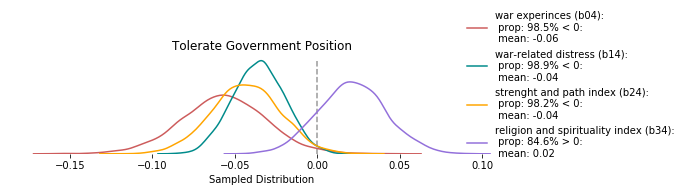

saved Tolerate_Government_Position_1.pdf


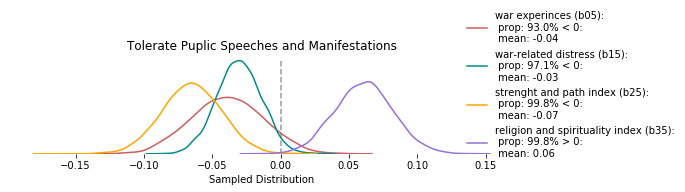

saved Tolerate_Puplic_Speeches_and_Manifestations_1.pdf


In [250]:
prop_plot(trace = trace1, labels = ['war experinces (b01)'] ,
          title='War-related Distress', trace_nr = '1')

prop_plot(trace = trace1, features = ['beta02','beta12'], 
          labels = ['war experinces (b02)','war-related distress (b12)'], 
          title='Strenght and Path Index', trace_nr = '1')

prop_plot(trace = trace1, features = ['beta03','beta13'], 
          labels = ['war experinces (b03)','war-related distress (b13)'], 
          title='Religion and Spirituality index', trace_nr = '1')

prop_plot(trace = trace1, features = ['beta04','beta14','beta24','beta34'], 
          labels = ['war experinces (b04)','war-related distress (b14)',
                    'strenght and path index (b24)','religion and spirituality index (b34)'], 
          title='Tolerate Government Position', trace_nr = '1')

prop_plot(trace = trace1, features = ['beta05','beta15','beta25','beta35'], 
          labels = ['war experinces (b05)','war-related distress (b15)',
                    'strenght and path index (b25)','religion and spirituality index (b35)'], 
          title='Tolerate Puplic Speeches and Manifestations', trace_nr = '1')

# Model 2: only new path(E2f from growth1) and religion(E2h from growth2)


In [26]:
# Features --------------------------------------------------------------
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['E2f'] # path
X3 = df_carolin['E2h'] # rligion

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Targets
Y0 = df_carolin['C30a'] # Position
Y1 = df_carolin['C30c'] # Speech

# Model ---------------------------------------------------------------------
model2 = pm.Model()

with model2:

    # Priors for unknown model parameters
    
    # All intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 5)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    
    # Beta for X1
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    # Betas for X2
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)
    
    # Betas for X3
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
    beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    # Betas for Y0
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
    beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)
    
    # Betas for Y1
    beta05 = pm.Normal('beta05', mu=0, sd=10, shape=1)
    beta15 = pm.Normal('beta15', mu=0, sd=10, shape=1)
    beta25 = pm.Normal('beta25', mu=0, sd=10, shape=1)
    beta35 = pm.Normal('beta35', mu=0, sd=10, shape=1)
    
    # Controls
    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4) # controls for X1: distrees 
    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4) # controls for Y0
    gamma5 = pm.Normal('gamma5', mu=0, sd=10, shape=4) # controls for Y1 

    # Vector of error-terms
    sigma = pm.HalfNormal('sigma', sd=1, shape=5)#A vector of error-terms

    

    # Expected value of outcome and
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    Y0_obs = pm.Normal('Y0_obs', mu=mu4, sd=sigma[3], observed=Y0)
    
    mu5 = alpha[4] + beta15 * X1_obs + beta05 * X0 + beta25 * X2_obs + beta35 * X3_obs + gamma5[0] * Z0 + gamma5[1] * Z1 + gamma5[2] * Z2 + gamma5[3] * Z3
    Y1_obs = pm.Normal('Y1_obs', mu=mu5, sd=sigma[4], observed=Y1)



In [27]:
with model2:
    # draw 1000 posterior samples
    trace2 = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(trace2).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma5, gamma4, gamma1, beta35, beta25, beta15, beta05, beta34, beta24, beta14, beta04, beta13, beta03, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:35<00:00, 83.82draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.516,0.385,0.006,-0.258,1.234,4120.225,1.0
alpha__1,2.676,0.204,0.003,2.257,3.052,4143.601,1.0
alpha__2,3.043,0.216,0.003,2.621,3.452,4072.586,1.0
alpha__3,0.659,0.137,0.002,0.409,0.935,4213.072,1.0
alpha__4,0.537,0.138,0.002,0.273,0.813,4458.861,1.0
beta01__0,0.207,0.088,0.001,0.026,0.367,7160.140,1.0
beta02__0,0.166,0.078,0.001,0.017,0.321,4457.335,1.0
beta12__0,0.023,0.045,0.000,-0.067,0.107,8455.626,1.0
beta03__0,0.188,0.083,0.001,0.033,0.360,4125.413,1.0
beta13__0,0.087,0.050,0.000,-0.008,0.186,8740.566,1.0


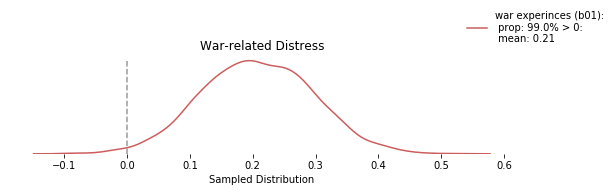

saved War_related_Distress_2.pdf


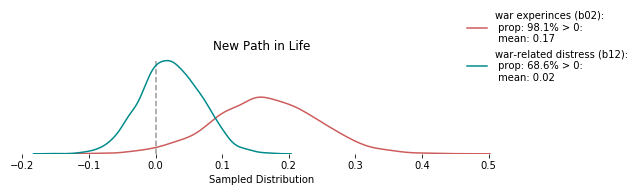

saved New_Path_in_Life_2.pdf


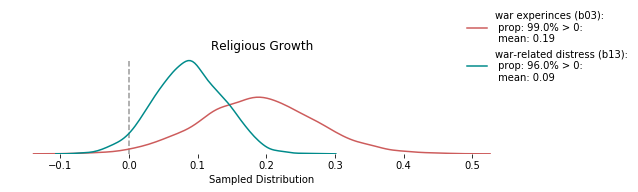

saved Religious_Growth_2.pdf


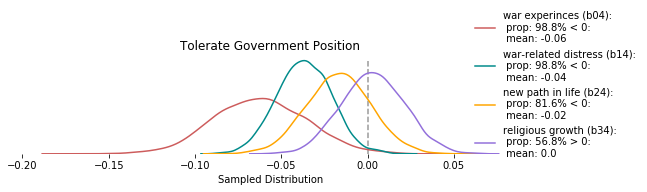

saved Tolerate_Government_Position_2.pdf


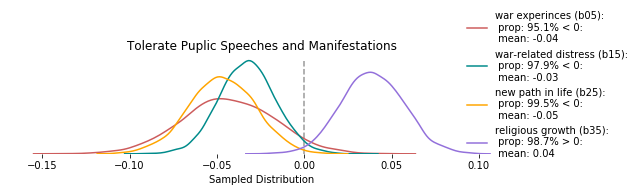

saved Tolerate_Puplic_Speeches_and_Manifestations_2.pdf


In [251]:
prop_plot(trace = trace2, labels = ['war experinces (b01)'] ,
          title='War-related Distress', trace_nr = '2')

prop_plot(trace = trace2, features = ['beta02','beta12'], 
          labels = ['war experinces (b02)','war-related distress (b12)'], 
          title='New Path in Life', trace_nr = '2')

prop_plot(trace = trace2, features = ['beta03','beta13'], 
          labels = ['war experinces (b03)','war-related distress (b13)'], 
          title='Religious Growth', trace_nr = '2')

prop_plot(trace = trace2, features = ['beta04','beta14','beta24','beta34'], 
          labels = ['war experinces (b04)','war-related distress (b14)',
                    'new path in life (b24)','religious growth (b34)'], 
          title='Tolerate Government Position', trace_nr = '2')

prop_plot(trace = trace2, features = ['beta05','beta15','beta25','beta35'], 
          labels = ['war experinces (b05)','war-related distress (b15)',
                    'new path in life (b25)','religious growth (b35)'], 
          title='Tolerate Puplic Speeches and Manifestations', trace_nr = '2')

In [29]:
pm.compare({model0:trace0,model1:trace1,model2:trace2}) # you need to do something clever here

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,4624.19,30.61,0,1,60.69,0,0
2,4767.41,30.82,143.22,0,61.53,18.12,0
0,4804.67,30.71,180.48,0,61.76,19.86,0


In [30]:
pm.compare({model0:trace0,model1:trace1,model2:trace2}, ic='LOO') # you need to do something clever here

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
1,4624.22,30.63,0,1,60.69,0,0
2,4767.46,30.84,143.24,0,61.53,18.12,0
0,4804.73,30.74,180.51,0,61.76,19.86,0


# Carolins model:

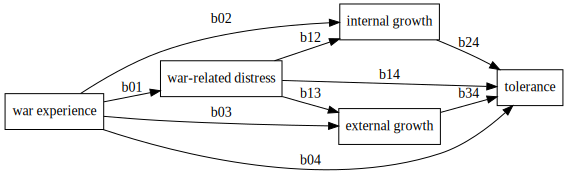

In [181]:
def viz_model():
    
    dot = graphviz.Digraph(comment='COMMENT')
    dot.attr(rankdir='LR', size='8,5', engine='neato')

    dot.attr('node', shape='box')

    dot.node('X0', 'war experience')
    dot.node('X1', 'war-related distress')
    dot.node('X2', 'internal growth')
    dot.node('X3', 'external growth')


    dot.node('Y0', 'tolerance')
    #dot.node('Y1', 'external growth')

    dot.edge('X0', 'X1', 'b01')
    dot.edge('X0', 'X2', 'b02')
    dot.edge('X0', 'X3', 'b03')
    dot.edge('X0', 'Y0', 'b04')
    #dot.edge('X0', 'Y1', 'b05')
    dot.edge('X1', 'X2', 'b12')
    dot.edge('X1', 'X3', 'b13')
    dot.edge('X1', 'Y0', 'b14')
    #dot.edge('X1', 'Y1', 'b15')
    dot.edge('X2', 'Y0', 'b24')
    #dot.edge('X2', 'Y1', 'b25')
    dot.edge('X3', 'Y0', 'b34')
    #dot.edge('X3', 'Y1', 'b35', constraint='false')
    dot.render('carolins_model', 'pdf')
    
    return(dot)

dot = viz_model()
dot

In [32]:
# Features. not as vectors for easier interpetation..
X0 = df_carolin['war']
X1 = df_carolin['distress']
X2 = df_carolin['growth1']
X3 = df_carolin['growth2']

# controls:
#Z = df_carolin[['gender','age','edu','eduf']]

Z0 = df_carolin['gender']
Z1 = df_carolin['age']
Z2 = df_carolin['edu']
Z3 = df_carolin['eduf']

# Target
Y = df_carolin['rights_sinhalese']

In [33]:
modelc = pm.Model()

with modelc:

    # Priors for unknown model parameters
    
    # A vector for all intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape = 4)# A vector of intercepts
    
    # For easier evalutation I have not made this a vecor of betas..
    # Beta for X1
    beta01 = pm.Normal('beta01', mu=0, sd=10, shape=1)
    
    # Betas for X2
    beta02 = pm.Normal('beta02', mu=0, sd=10, shape=1)
    beta12 = pm.Normal('beta12', mu=0, sd=10, shape=1)

    # Betas for X3
    beta03 = pm.Normal('beta03', mu=0, sd=10, shape=1)
    beta13 = pm.Normal('beta13', mu=0, sd=10, shape=1)
    
    # Betas for Y
    beta04 = pm.Normal('beta04', mu=0, sd=10, shape=1)
    beta14 = pm.Normal('beta14', mu=0, sd=10, shape=1)
    beta24 = pm.Normal('beta24', mu=0, sd=10, shape=1)
    beta34 = pm.Normal('beta34', mu=0, sd=10, shape=1)
    
    # Controls
    gamma1 = pm.Normal('gamma1', mu=0, sd=10, shape=4) # controls for X1

    gamma4 = pm.Normal('gamma4', mu=0, sd=10, shape=4) # COntrols for Y
    
    # Vector of all error-terms
    sigma = pm.HalfNormal('sigma', sd=1, shape=4)#A vector of error-terms

    

    # Expected value of outcome
    # Likelihood (sampling distribution) of observations
    mu1 = alpha[0] + beta01 * X0 + gamma1[0] * Z0 + gamma1[1] * Z1 + gamma1[2] * Z2 + gamma1[3] * Z3
    X1_obs = pm.Normal('X1_obs', mu=mu1, sd=sigma[0], observed=X1)
    
    mu2 = alpha[1] + beta02 * X0 + beta12 * X1_obs
    X2_obs = pm.Normal('X2_obs', mu=mu2, sd=sigma[1], observed=X2)
    
    mu3 = alpha[2] + beta03 * X0 + beta13 * X1_obs
    X3_obs = pm.Normal('X3_obs', mu=mu3, sd=sigma[2], observed=X3)
    
    mu4 = alpha[3] + beta14 * X1_obs + beta04 * X0 + beta24 * X2_obs + beta34 * X3_obs + gamma4[0] * Z0 + gamma4[1] * Z1 + gamma4[2] * Z2 + gamma4[3] * Z3
    Y_obs = pm.Normal('Y_obs', mu=mu4, sd=sigma[3], observed=Y)


In [34]:
with modelc:
    # draw 500 posterior samples
    tracec = pm.sample(1000, tune = 1000, nuts_kwargs=dict(target_accept=.80))
    #trace = pm.sample(1000, chains=2, tune=2000, random_seed=42, nuts_kwargs=dict(target_accept=.90))
    
pm.summary(tracec).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma4, gamma1, beta34, beta24, beta14, beta04, beta13, beta03, beta12, beta02, beta01, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:15<00:00, 105.44draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.519,0.378,0.007,-0.216,1.247,3378.570,1.0
alpha__1,2.573,0.148,0.002,2.269,2.848,4679.504,1.0
alpha__2,2.623,0.163,0.003,2.290,2.923,3901.384,1.0
alpha__3,1.579,0.269,0.004,1.047,2.082,4470.991,1.0
beta01__0,0.210,0.086,0.001,0.035,0.375,5816.239,1.0
beta02__0,0.255,0.056,0.001,0.145,0.365,4479.685,1.0
beta12__0,0.052,0.035,0.000,-0.018,0.116,6477.781,1.0
beta03__0,0.189,0.063,0.001,0.066,0.310,4112.541,1.0
beta13__0,0.093,0.037,0.000,0.022,0.165,8787.431,1.0
beta04__0,-0.140,0.053,0.001,-0.247,-0.040,7914.990,1.0


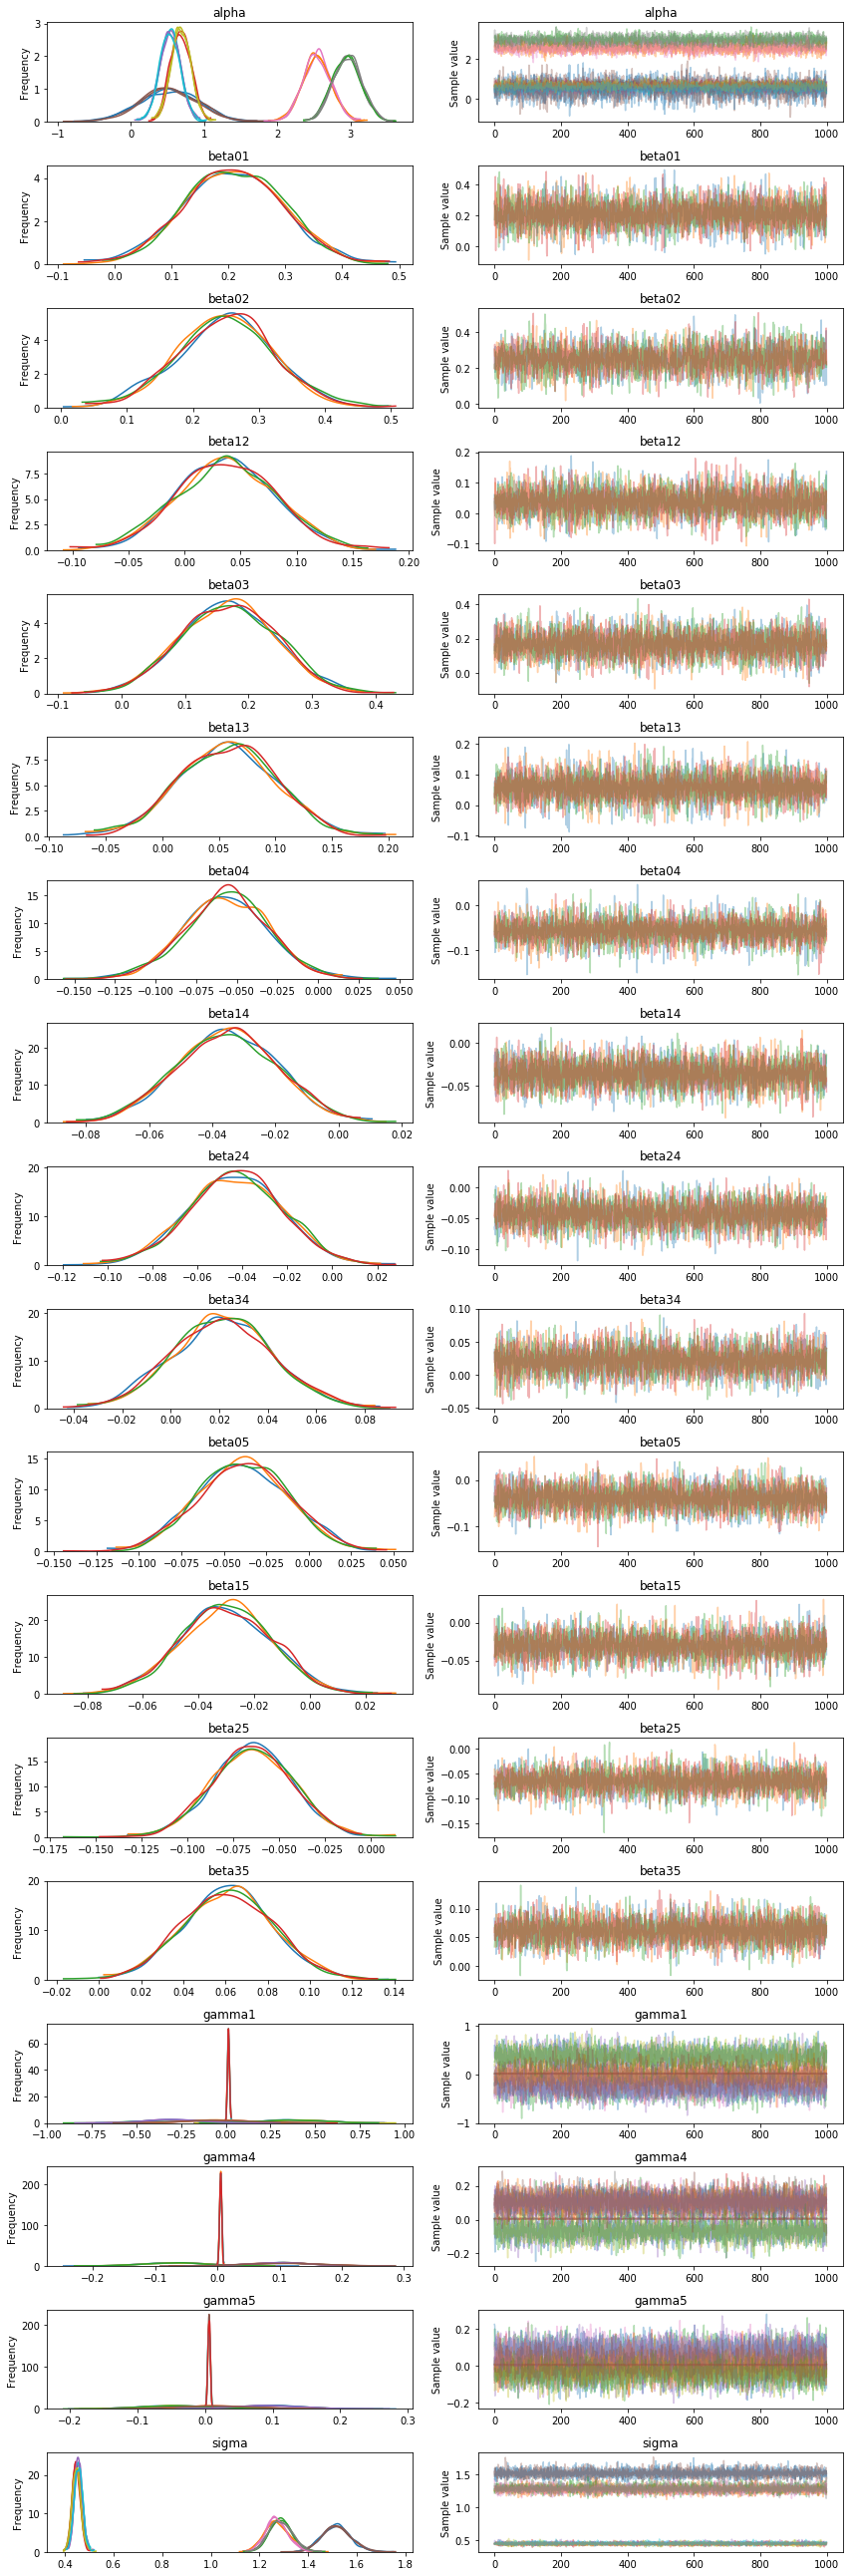

In [35]:
pm.traceplot(trace1)
plt.show()

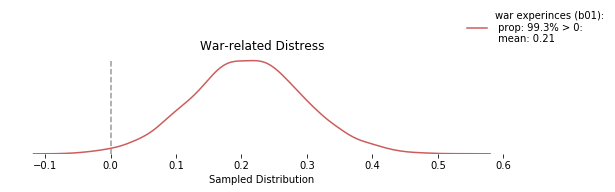

saved War_related_Distress_c.pdf


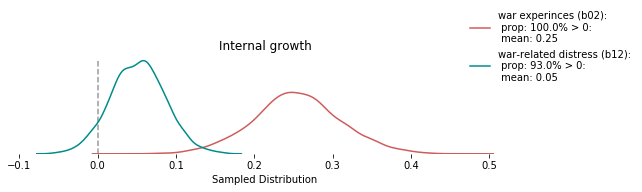

saved Internal_growth_c.pdf


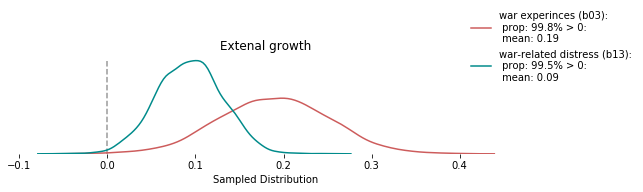

saved Extenal_growth_c.pdf


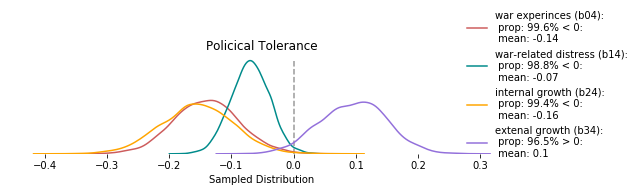

saved Policical_Tolerance_c.pdf


In [252]:
prop_plot(trace = tracec, labels = ['war experinces (b01)'] ,
          title='War-related Distress', trace_nr = 'c')

prop_plot(trace = tracec, features = ['beta02','beta12'], 
          labels = ['war experinces (b02)','war-related distress (b12)'], 
          title='Internal growth', trace_nr = 'c')

prop_plot(trace = tracec, features = ['beta03','beta13'], 
          labels = ['war experinces (b03)','war-related distress (b13)'], 
          title='Extenal growth', trace_nr = 'c')

prop_plot(trace = tracec, features = ['beta04','beta14','beta24','beta34'], 
          labels = ['war experinces (b04)','war-related distress (b14)',
                    'internal growth (b24)','extenal growth (b34)'], 
          title='Policical Tolerance', trace_nr = 'c')

** hvis du holder det den sørrelse skal du finde på noget med legends.**

In [144]:
pm.waic(tracec,modelc)

WAIC_r(WAIC=4342.050851560871, WAIC_se=42.94535980019888, p_WAIC=22.84725051772667, var_warn=0)

In [145]:
pm.loo(tracec,modelc)

LOO_r(LOO=4342.085714053516, LOO_se=42.94682785350523, p_LOO=22.864681764049237, shape_warn=0)

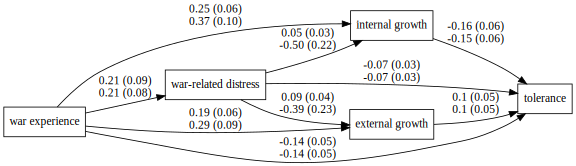

In [199]:
def viz_model_est():
    
    dot = graphviz.Digraph(comment='COMMENT')
    dot.attr(rankdir='LR', size='8,5', engine='neato')

    dot.attr('node', shape='box')

    dot.node('X0', 'war experience')
    dot.node('X1', 'war-related distress')
    dot.node('X2', 'internal growth')
    dot.node('X3', 'external growth')


    dot.node('Y0', 'tolerance')
    
    beta_dict = {}
    beta_list = ['beta01', 'beta02', 'beta03', 'beta04',
                 'beta12', 'beta13', 'beta14',
                'beta24','beta34']
    
    for i in range(len(beta_list)):
        #beta_dict[beta_list[i]] = str(round(tracec.get_values(beta_list[i])[:,0].mean(),2)) + '({})'.format(1)
        mean = round(tracec.get_values(beta_list[i])[:,0].mean(),2)
        std =  round(tracec.get_values(beta_list[i])[:,0].std(),2)
        
        beta_dict[beta_list[i]] = '{} ({})'.format(mean,std)

    

    dot.edge('X0', 'X1', beta_dict['beta01'] + '\n0.21 (0.08)')
    dot.edge('X0', 'X2', beta_dict['beta02'] + '\n0.37 (0.10)')
    dot.edge('X0', 'X3', beta_dict['beta03'] + '\n0.29 (0.09)')
    dot.edge('X0', 'Y0', beta_dict['beta04'] + '\n-0.14 (0.05)')
    dot.edge('X1', 'X2', beta_dict['beta12'] + '\n-0.50 (0.22)')
    dot.edge('X1', 'X3', beta_dict['beta13'] + '\n-0.39 (0.23)')
    dot.edge('X1', 'Y0', beta_dict['beta14'] + '\n-0.07 (0.03)')
    dot.edge('X2', 'Y0', beta_dict['beta24'] + '\n-0.15 (0.06)')
    dot.edge('X3', 'Y0', beta_dict['beta34'] +'\n0.1 (0.05)')
    dot.render('carolins_model_est', 'pdf')
    
    return(dot)

dot = viz_model_est()
dot